In [1]:
from fastai.vision.all import *
from fastai.vision.gan import *
from fastai.distributed import *
from fastai.metrics import error_rate
from fastai.callback.tracker import SaveModelCallback
import torch 
from fastai.metrics import *

In [2]:
from models.backbone import Backbone
from models.encoder import EncoderModule
from models.utils.joiner2 import *
from models.utils.losses import *
from models.utils.metrics import Accuracy
from models.unet import UNet
from models.utils.misc import *
from models.utils.datasets import *
import torchvision.transforms as T
import torchvision.transforms as T
from torchvision import datasets, transforms, models
from collections import defaultdict, deque
import itertools

from skimage import io
from PIL import *

import time

In [3]:
# from torchvision.datasets.imagenet import ImageNet

# import random

# from torchvision.transforms.functional import *

# from collections import defaultdict, deque
# import itertools

In [4]:
seed = 23456
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
H = 320
W= 320
bs=10

transform = T.Compose([
T.Resize((H,W))#,
#T.ToTensor(),
#T.Normalize([0.485, 0.456, 0.406], [0.485, 0.456, 0.406])
])

In [6]:
# class ImagenetRotation(datasets.ImageNet):
#     def __init__(self, path, transforms, size, train=True):
#         super().__init__(path)
#         self.transforms = transforms
#         self.size = size
#         self.degrees = [0,90,180,270]
#         self.labelDict = {0:0,90:1,180:2,270:3}
#         self.deg = {}
#         self.indexes = self.create_idx()

#     def create_idx(self):
#         indexes = {}
#         self.deg = {}
#         i = 0
#         while len(indexes) < (self.size):
#             r=random.randint(0,1281166)
#             if r not in indexes.values() : 
#                 indexes[i] = r
#                 self.deg[i] = random.choice(self.degrees)
#                 i +=1

#         return indexes

#     def __len__(self):
#         return len(self.indexes)

#     def __getitem__(self, index):
#         ind = self.indexes[index]
#         im, _ = super().__getitem__(ind)
#         dgr = self.deg[index]
#         self.category = self.labelDict[dgr] 
#         return rotate(self.transforms(im),dgr), self.category

In [7]:
ds = ImagenetRotation(path='./data', transforms=transform, size=1000)

In [8]:
for i in range(10):
    print(ds[i])

(<PIL.Image.Image image mode=RGB size=320x320 at 0x7F4614583550>, 2)
(<PIL.Image.Image image mode=RGB size=320x320 at 0x7F4614583520>, 0)
(<PIL.Image.Image image mode=RGB size=320x320 at 0x7F4614583550>, 1)
(<PIL.Image.Image image mode=RGB size=320x320 at 0x7F4614583610>, 0)
(<PIL.Image.Image image mode=RGB size=320x320 at 0x7F46145831F0>, 0)
(<PIL.Image.Image image mode=RGB size=320x320 at 0x7F4614583550>, 1)
(<PIL.Image.Image image mode=RGB size=320x320 at 0x7F4614583610>, 0)
(<PIL.Image.Image image mode=RGB size=320x320 at 0x7F4614583520>, 1)
(<PIL.Image.Image image mode=RGB size=320x320 at 0x7F4614583580>, 1)
(<PIL.Image.Image image mode=RGB size=320x320 at 0x7F46145835B0>, 2)


2


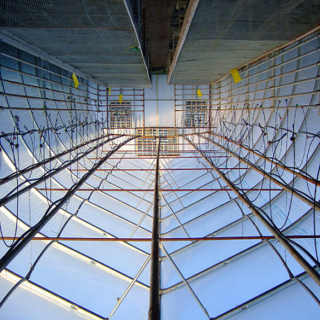

In [9]:
i = 0
print(ds[i][1])
ds[i][0]

In [10]:
since = time.time()
for i in range(len(ds)):
    #io.imsave('./data/myData/img{}.jpeg'.format(i), ds[i][0])
    #torch.save(ds[i][0], './data/myData/img{}.jpg'.format(i))
    ds[i][0].save('./data/ImageNetRotation1k/{}/img{}.jpg'.format(ds[i][1],i))
    if i%100==0:
        print(i,"imagens salvas")
        time_elapsed = time.time() - since
        print('Data Preprocessing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
        since = time.time()

0 imagens salvas
Data Preprocessing complete in 0m 0s
100 imagens salvas
Data Preprocessing complete in 0m 4s
200 imagens salvas
Data Preprocessing complete in 0m 4s
300 imagens salvas
Data Preprocessing complete in 0m 4s
400 imagens salvas
Data Preprocessing complete in 0m 4s
500 imagens salvas
Data Preprocessing complete in 0m 4s
600 imagens salvas
Data Preprocessing complete in 0m 4s
700 imagens salvas
Data Preprocessing complete in 0m 4s
800 imagens salvas
Data Preprocessing complete in 0m 4s
900 imagens salvas
Data Preprocessing complete in 0m 4s


In [22]:
path = './data/ImageNetRotation100k/'

transform = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(H,W),
                 batch_tfms=transform)

dld = data.dataloaders(path,bs=bs) 

In [23]:
generator_loss = Generator_loss3(beta=0, gamma=0.005,sigma=1)
critic_loss = CriticLoss(beta=0, sigma=1)

In [24]:
gan = GAN(num_encoder_layers = 4, nhead=4, backbone = True, num_classes = 4, bypass=False, hidden_dim=256, batch_size=bs, image_h=H, image_w=W,grid_l=4,penalty_factor="2")

In [25]:
critic_learn = Learner(dld, gan, loss_func=critic_loss, metrics=[Accuracy])

In [26]:
generator_learn = Learner(dld, gan, loss_func=generator_loss)

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=7.585775847473997e-07)

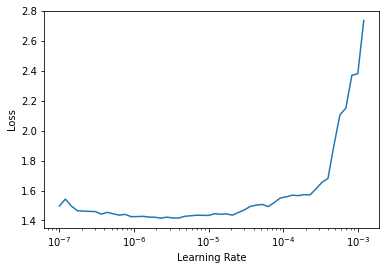

In [27]:
critic_learn.lr_find()

SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=9.120108734350652e-05)

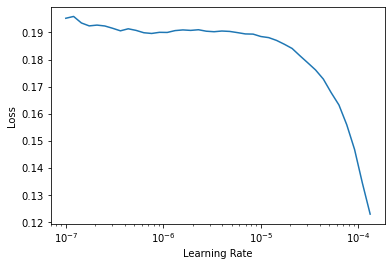

In [28]:
generator_learn.lr_find()

In [143]:
epochs = 1

In [144]:
for e in range(epochs):
    print("Epoch", e+1)
    print("Generator training")
    #Generator Training
    for param in gan.generator.parameters():
        param.requires_grad = True
    for param in gan.model.parameters():
        param.requires_grad = False
    gan.noise_mode = True
    
    generator_learn.fit_one_cycle(1,0.001)
    
    print("Critit training without noised images")
    #Critit training without noised images
    for param in gan.generator.parameters():
        param.requires_grad = False
    fb = ["mask","penalty_mask","pos"]
    for name, p in gan.model.named_parameters(): 
        if name not in fb:
            p.requires_grad_(True)
    gan.noise_mode = False
    critic_learn.fit(1,1e-7)
    print("Critit training with noised images")
    #Critit training with noised images
    gan.noise_mode = True
    critic_learn.fit(1,1e-7)

Epoch 1
Generator training


epoch,train_loss,valid_loss,time
0,0.075483,0.003401,00:07


Critit training without noised images


epoch,train_loss,valid_loss,Accuracy,time
0,1.423274,1.566440,0.150000,00:05


Critit training with noised images


epoch,train_loss,valid_loss,Accuracy,time
0,1.448274,1.505018,0.150000,00:06


In [46]:
for param in gan.generator.parameters():
    param.requires_grad = False
fb = ["mask","penalty_mask","pos"]
for name, p in gan.model.named_parameters(): 
    if name not in fb:
        p.requires_grad_(True)

In [49]:
gan.noise_mode = True

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=5.754399353463668e-06)

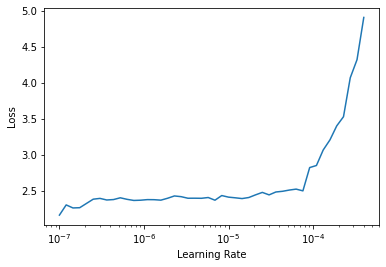

In [50]:
critic_learn.lr_find()

In [35]:
critic_learn.fit(1,2e-6)

epoch,train_loss,valid_loss,Accuracy,time
0,1.763650,1.701412,0.431750,09:57


torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Si

torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Si

torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Si

torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Si

torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Si

torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Si

torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Si

torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Si

torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Si

torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Si

torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Size([5])
torch.Size([5, 10])
torch.Si

In [43]:
for param in gan.generator.parameters():
    param.requires_grad = True
for param in gan.model.parameters():
    param.requires_grad = False

In [44]:
gan.noise_mode = True

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.001737800776027143)

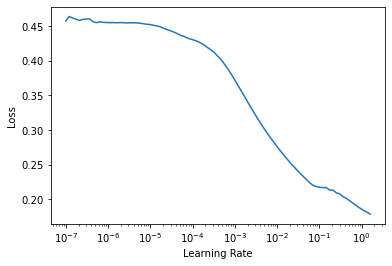

In [45]:
generator_learn.lr_find()